In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing

from src.mlhgp import MLHGP

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

# Test Data

In [3]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Training Data

In [4]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=25).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

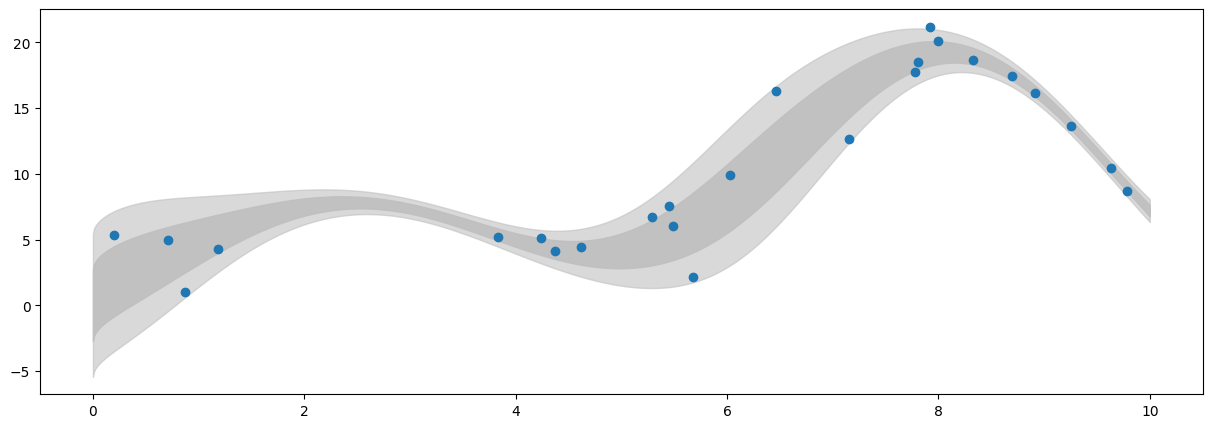

In [5]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

# Most Likely Heteroscedastic Gaussian Process approach

In [6]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_norm = normalizer.transform(X)

# define the model
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
model_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)

hgp = MLHGP(model, model_noise, max_iter=10)

# fit the model
hgp.fit(X_train_norm, y_train.flatten(), print_noise_rmse=False)

# make a prediction 
Y_pred, Std_pred = hgp.predict(X_norm, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/faz

In [7]:
hgp.model.kernel_

9.55**2 * RBF(length_scale=0.726) + WhiteKernel(noise_level=1e-05)

In [8]:
hgp.model_noise.kernel_

0.981**2 * RBF(length_scale=0.399) + WhiteKernel(noise_level=0.402)

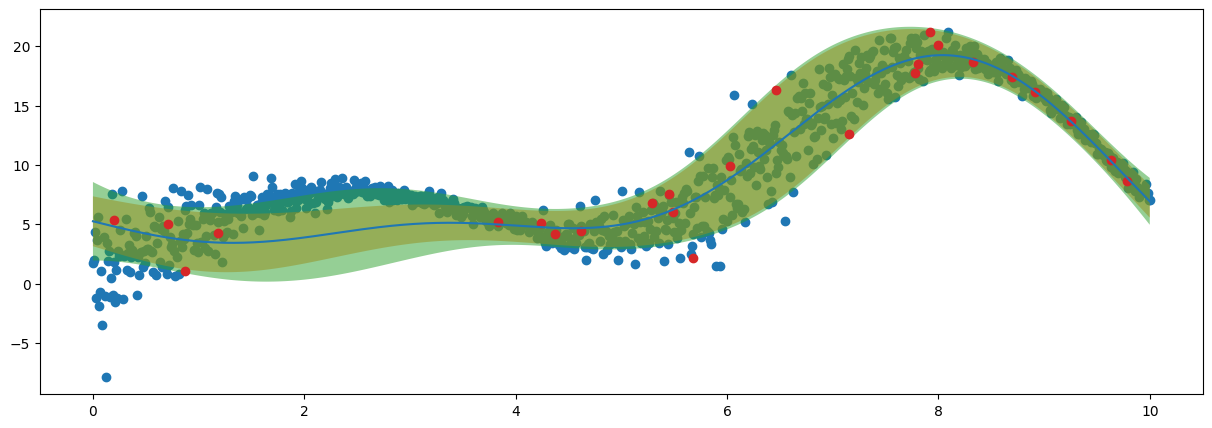

In [9]:
plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X, Y_pred)
plt.scatter(X_train, y_train)

In [10]:
np.sqrt(hgp.variance_est)

array([0.87426102, 2.84943065, 1.28208503, 1.33581302, 0.68652839,
       3.46892547, 0.74104353, 0.59501409, 0.62047957, 0.68221824,
       1.61726014, 1.15217175, 3.55452795, 0.58497292, 1.14780636,
       2.05536902, 0.9452164 , 0.6872361 , 1.19948676, 0.6088536 ,
       0.66031056, 0.97701204, 0.68118458, 0.89440044, 1.05072541])

In [11]:
hgp.model_noise.predict(X_train)

array([-2.46761099e-25, -4.60520407e-48, -7.05148766e-32, -6.88754242e-25,
       -3.38791859e-13, -1.11287386e-37, -2.44562662e-14, -1.92100004e-80,
       -4.63022296e-96, -3.40804507e-10, -4.71299025e-61, -4.05699151e-23,
       -1.41402741e-27, -1.29100878e-87,  2.22638964e-01, -4.94798221e-01,
        1.77322844e+00, -1.19554053e-68, -1.23786114e-58, -5.40989046e-76,
       -1.73569567e-99, -2.12093081e-62, -2.03677410e-16, -4.71264320e-59,
       -1.01421684e+00])

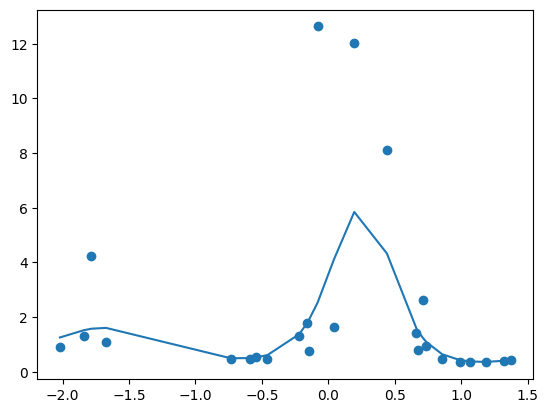

In [12]:
sorted_xtrain = np.sort(X_train_norm, axis=0)
plt.scatter(X_train_norm,(hgp.variance_est))
plt.plot(sorted_xtrain, np.exp(hgp.model_noise.predict(sorted_xtrain)))

In [13]:
np.sort(X_train, axis=0)

array([[0.20218397],
       [0.71036058],
       [0.871293  ],
       [1.18274426],
       [3.83441519],
       [4.23654799],
       [4.37587211],
       [4.61479362],
       [5.2889492 ],
       [5.44883183],
       [5.48813504],
       [5.68044561],
       [6.02763376],
       [6.45894113],
       [7.15189366],
       [7.78156751],
       [7.80529176],
       [7.91725038],
       [7.99158564],
       [8.32619846],
       [8.70012148],
       [8.91773001],
       [9.25596638],
       [9.63662761],
       [9.78618342]])

In [14]:
a = 2
a_x = np.array([3,3,4,6,8,1,0,4,4,5])
ax_mean = a_x.mean()

In [15]:
np.sum((a - a_x)**2)/len(a_x)

8.0

In [16]:
(a-ax_mean)**2 + np.var(a_x)

7.999999999999999